In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
import sys
import time
import sqlite3
from scipy.stats import rankdata
from scipy.stats import stats
from scipy.optimize import minimize

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


SPY(S&P 500), IWM(Russel 2000), QQQ(Nasdaq), VGK(Europe), EWJ(Japan), VWO(Emerging), VNQ(US REITs), GSG(Commodity), GLD(Gold), TLT(US Long-term Treasury), HYG(High Yield Bond), LQD(US Corporate Bond)를 공격 자산으로, SHY(US Short-term Treasury), IEF(US Intermediate-term Treasury), LQD(US Corporate Bond)를 방어 자산으로 DAA(Defensive Asset Allocation) 전략을 구현해 보겠습니다. 상대 모멘텀을 적용하여 12개 공격 자산 중 모멘텀이 가장 좋은 6개를 삽니다. BND(US Total Bond), VWO(Emerging) 두 개를 카나리아 자산으로 하여 둘 다 모멘텀이 +면 공격 자산 100%, 하나만 +면 공격 자산 50%(모멘텀 상위 공격자산 3개를 16.67%씩, 방어자산 50%), 둘 다 -면 공격 자산 0% 보유합니다. 모멘텀은 1개월 수익 * 12 + 3개월 수익 * 4 + 6개월 수익 * 2 + 12개월 수익 * 1로 계산합니다. 공격 자산 비중이 100%가 아닌 경우는 방어 자산을 보유하는데, 방어 자산은 3가지 중 모멘텀이 가장 좋은 1개를 보유합니다. 리밸런싱은 월간입니다. BND와 HYG가 2007년 4월에 생겼으므로 2007년 5월부터 수집합니다.

In [2]:
start = '2007-05-02'
end = '2021-02-26'

spy = web.DataReader('SPY', 'yahoo', start, end)
iwm = web.DataReader('IWM', 'yahoo', start, end)
qqq = web.DataReader('QQQ', 'yahoo', start, end)
vgk = web.DataReader('VGK', 'yahoo', start, end)
ewj = web.DataReader('EWJ', 'yahoo', start, end)
vwo = web.DataReader('VWO', 'yahoo', start, end)
vnq = web.DataReader('VNQ', 'yahoo', start, end)
gsg = web.DataReader('GSG', 'yahoo', start, end)
gld = web.DataReader('GLD', 'yahoo', start, end)
tlt = web.DataReader('TLT', 'yahoo', start, end)
hyg = web.DataReader('HYG', 'yahoo', start, end)
lqd = web.DataReader('LQD', 'yahoo', start, end)
shy = web.DataReader('SHY', 'yahoo', start, end)
ief = web.DataReader('IEF', 'yahoo', start, end)
bnd = web.DataReader('BND', 'yahoo', start, end)

In [3]:
price_data = [spy, iwm, qqq, vgk, ewj, vwo, vnq, gsg, gld, tlt, hyg, lqd, shy, ief, bnd]
Total = ['SPY','IWM','QQQ','VGK','EWJ','VWO','VNQ','GSG','GLD','TLT','HYG','LQD','SHY','IEF','BND']

In [4]:
MomentumScore = pd.DataFrame(index = spy.index)

for i in range(len(price_data)):
    
    temp = []
    asset = price_data[i]
    
    for j in range(len(asset)):
        Momentum = asset['Adj Close'].pct_change(periods=21)[j] * 12 + asset['Adj Close'].pct_change(periods=63)[j] * 4 + asset['Adj Close'].pct_change(periods=126)[j] * 2 + asset['Adj Close'].pct_change(periods=252)[j]
        temp.append(Momentum)
    
    MomentumScore[Total[i]] = temp

MomentumScore = MomentumScore.dropna(axis=0)

In [5]:
def CalCanary(df):
    temp = []
    for i in range(len(df)):
        if df[i] > 0:
            temp.append(1)
        else:
            temp.append(0)
    
    return temp

In [6]:
CanaryScore = pd.DataFrame(index = MomentumScore.index)
BNDMomentum = MomentumScore['BND']
VWOMomentum = MomentumScore['VWO']

CanaryScore['BND'] = CalCanary(BNDMomentum)
CanaryScore['VWO'] = CalCanary(VWOMomentum)
CanaryScore['TOTAL'] = (CanaryScore['BND'] + CanaryScore['VWO'])/2

In [7]:
CanaryMonth = CanaryScore.resample(rule='M').apply(lambda x: x[-1])
MomentumMonth = MomentumScore.resample(rule='M').apply(lambda x: x[-1])

In [8]:
AssetSelector = MomentumMonth.loc[:, ['SPY','IWM','QQQ','VGK','EWJ','VWO','VNQ','GSG','GLD','TLT','HYG','LQD','SHY','IEF']]

In [15]:
asset1 = []
asset2 = []
asset3 = []
asset4 = []
asset5 = []
asset6 = []
asset7 = []

for i in range(len(AssetSelector)):
    # 공격자산만 추출 (index 0~11)
    target = AssetSelector.iloc[i, 0:12]
    
    if CanaryMonth.iloc[i,2] == 1.0:
        targetrank = target.rank(ascending=False)
        a1 = targetrank[targetrank==1.0].index[0]
        asset1.append(a1)
        a2 = targetrank[targetrank==2.0].index[0]
        asset2.append(a2)
        a3 = targetrank[targetrank==3.0].index[0]
        asset3.append(a3)
        a4 = targetrank[targetrank==4.0].index[0]
        asset4.append(a4)
        a5 = targetrank[targetrank==5.0].index[0]
        asset5.append(a5)
        a6 = targetrank[targetrank==6.0].index[0]
        asset6.append(a6)
        
        # 카나리아 점수 1.0일 경우 공격자산 6개만 선택
        asset7.append(np.nan)
        
    if CanaryMonth.iloc[i,2] == 0.5:
        targetrank = target.rank(ascending=False)
        a1 = targetrank[targetrank==1.0].index[0]
        asset1.append(a1)
        a2 = targetrank[targetrank==2.0].index[0]
        asset2.append(a2)
        a3 = targetrank[targetrank==3.0].index[0]
        asset3.append(a3)
        a4 = targetrank[targetrank==4.0].index[0]
        asset4.append(a4)
        a5 = targetrank[targetrank==5.0].index[0]
        asset5.append(a5)
        a6 = targetrank[targetrank==6.0].index[0]
        asset6.append(a6)
        
        # 카나리아 점수 0.5면 방어자산 중 모멘텀 가장 좋은 것 1개 선택 필요
        # 방어자산만 추출 (index 11~13)
        bondtarget = AssetSelector.iloc[i, 11:14]
        bondtargetrank = bondtarget.rank(ascending=False)
        
        a7 = bondtargetrank[bondtargetrank==1.0].index[0]
        asset7.append(a7)
        
    # 카나리아 점수 0이면 공격자산 선택 없이 방어 자산 중 1개만 선택
    if CanaryMonth.iloc[i,2] == 0:
        asset1.append(np.nan)
        asset2.append(np.nan)
        asset3.append(np.nan)
        asset4.append(np.nan)
        asset5.append(np.nan)
        asset6.append(np.nan)
        
        bondtarget = AssetSelector.iloc[i, 11:14]
        bondtargetrank = bondtarget.rank(ascending=False)
        
        a7 = bondtargetrank[bondtargetrank==1.0].index[0]
        asset7.append(a7)
        
AssetSelector['ASSET1'] = asset1
AssetSelector['ASSET2'] = asset2
AssetSelector['ASSET3'] = asset3
AssetSelector['ASSET4'] = asset4
AssetSelector['ASSET5'] = asset5
AssetSelector['ASSET6'] = asset6
AssetSelector['ASSET7'] = asset7

In [16]:
MonthlyReturn = pd.DataFrame(index = AssetSelector.index)

# price_data에 저장된 가격 데이터
for i in range(len(price_data)):
    
    temp = price_data[i].loc[:, 'Adj Close'].to_frame()
    # 가격 데이터 월말 기준으로 resample
    temp = temp.resample(rule='M').apply(lambda x: x[-1])
    # 수익률 계산
    temp = temp.pct_change()   
    temp.columns = [Total[i]]
  
    temp = temp.iloc[12:, :]
    
    MonthlyReturn = pd.concat([MonthlyReturn, temp], axis=1, join='inner')

In [26]:
MonthlyReturn

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,HYG,LQD,SHY,IEF,BND
Date,,,,,,,,,,,,,,,
2008-05-31,0.015117,0.045798,0.059310,0.006703,0.019579,0.017850,-0.002109,0.084665,0.009232,-0.026883,-0.005085,-0.022051,-0.003461,-0.017776,-0.009939
2008-06-30,-0.083576,-0.075264,-0.096151,-0.089887,-0.074608,-0.098092,-0.106154,0.103240,0.045169,0.026537,-0.036747,-0.012918,0.002455,0.011459,0.000420
2008-07-31,-0.008986,0.036730,0.006420,-0.028807,-0.037691,-0.047222,0.031154,-0.133227,-0.014442,-0.003674,0.005902,0.003900,0.004343,0.007207,0.000211
2008-08-31,0.015454,0.035754,0.014519,-0.038450,-0.049167,-0.079165,0.023739,-0.074850,-0.092917,0.027392,-0.008977,0.001449,0.004664,0.015266,0.008378
2008-09-30,-0.094174,-0.077514,-0.155762,-0.128937,-0.065731,-0.155870,-0.001237,-0.104378,0.041121,0.014760,-0.106559,-0.107305,0.007779,-0.001403,-0.005156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-31,-0.024934,0.022031,-0.030449,-0.054167,-0.014051,0.013182,-0.030015,-0.034419,-0.005194,-0.033852,0.004034,-0.005104,-0.000463,-0.013808,-0.005564
2020-11-30,0.108777,0.182442,0.112258,0.163944,0.105598,0.085597,0.096749,0.122351,-0.054086,0.016639,0.033512,0.037715,0.000220,0.003384,0.012135
2020-12-31,0.037048,0.086465,0.049024,0.056776,0.053352,0.059994,0.027341,0.058369,0.070139,-0.012276,0.019579,0.001506,0.000405,-0.002385,0.001526


In [27]:
AssetSelector

,SPY,IWM,QQQ,VGK,EWJ,VWO,VNQ,GSG,GLD,TLT,...,LQD,SHY,IEF,ASSET1,ASSET2,ASSET3,ASSET4,ASSET5,ASSET6,ASSET7
Date,,,,,,,,,,,,,,,,,,,,,
2008-04-30,0.025147,-0.123024,0.463928,0.228526,0.563473,1.074037,0.367213,2.923758,0.253601,0.087294,...,0.262062,0.124217,0.098798,GSG,VWO,EWJ,QQQ,HYG,VNQ,NaN
2008-05-31,0.258025,0.741028,1.377444,0.174180,0.450183,0.631959,0.451551,2.987151,0.280085,-0.385256,...,-0.293006,0.042313,-0.166113,GSG,QQQ,IWM,VWO,VNQ,EWJ,SHY
2008-06-30,-1.613934,-1.355590,-1.490133,-1.742710,-1.195834,-1.488956,-1.862055,4.106780,1.375632,0.449989,...,-0.232988,0.122326,0.247123,GSG,GLD,TLT,LQD,HYG,EWJ,IEF
2008-07-31,-0.783372,0.326128,-0.385650,-0.896196,-1.152536,-0.937036,-0.038753,-0.440045,0.293323,0.036598,...,-0.124237,0.159953,0.244107,IWM,GLD,TLT,VNQ,HYG,LQD,IEF
2008-08-31,-0.239482,0.572688,0.033324,-1.343183,-1.537907,-2.181290,0.188245,-0.940383,-1.476852,0.664483,...,-0.054815,0.159782,0.417622,TLT,IWM,VNQ,QQQ,LQD,SPY,IEF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-31,0.034481,0.629431,0.335604,-0.848319,0.363961,0.722086,-0.771958,-0.283137,0.063645,-0.678193,...,-0.025174,0.027519,-0.189220,VWO,IWM,EWJ,QQQ,HYG,GLD,SHY
2020-11-30,1.873633,3.392720,2.090119,2.556722,2.031793,1.869186,1.292502,1.661903,-0.731231,0.186853,...,0.733396,0.033347,0.053149,IWM,VGK,QQQ,EWJ,SPY,VWO,NaN
2020-12-31,1.353164,3.059428,1.835651,1.434585,1.579237,1.686167,0.593879,1.561914,0.944536,0.013420,...,0.367259,0.044283,0.055853,IWM,QQQ,VWO,EWJ,GSG,VGK,NaN


In [22]:
DAAReturn = pd.DataFrame(index = MonthlyReturn.index)
tempReturn = []

for i in range(len(MonthlyReturn)):
    # AssetSelector의 Asset1 열이 Nan --> 방어자산 100%인 상황, Asset7만 체크
    if type(AssetSelector.iloc[i,14]) != str:
        asset = AssetSelector.iloc[i,20]
        
        targetreturn = MonthlyReturn[asset][i] * 1.0
        
        tempReturn.append(targetreturn)
    
    # AssetSelector의 Asset7 열이 Nan --> 공격자산 100%인 상황
    if type(AssetSelector.iloc[i,20]) != str:
        asset1 = AssetSelector.iloc[i,14]
        asset2 = AssetSelector.iloc[i,15]
        asset3 = AssetSelector.iloc[i,16]
        asset4 = AssetSelector.iloc[i,17]
        asset5 = AssetSelector.iloc[i,18]
        asset6 = AssetSelector.iloc[i,19]
        
        targetreturn = (MonthlyReturn[asset1][i] + MonthlyReturn[asset2][i] + MonthlyReturn[asset3][i] + MonthlyReturn[asset4][i] + MonthlyReturn[asset5][i] + MonthlyReturn[asset6][i])/6
        
        tempReturn.append(targetreturn)
    
    # 공격자산 상위 3개 16.6%씩, 방어자산 1개 50%
    if type(AssetSelector.iloc[i,14]) == str and type(AssetSelector.iloc[i,20]) == str:
        asset1 = AssetSelector.iloc[i,14]
        asset2 = AssetSelector.iloc[i,15]
        asset3 = AssetSelector.iloc[i,16]
        asset4 = AssetSelector.iloc[i,20]
        
        targetreturn = (MonthlyReturn[asset1][i] + MonthlyReturn[asset2][i] + MonthlyReturn[asset3][i])/6 + MonthlyReturn[asset4][i]/2
        
        tempReturn.append(targetreturn)

DAAReturn['DAA'] = tempReturn

월간 수익률 데이터로 계산을 하여 quantstats 패키지의 reports.plots 함수에서 샤프 비율을 제대로 계산하지 못하고 있습니다. 아래 그림의 daily return 그래프는 현재 월간 수익률 기준으로 만들었으니 monthly return 그래프일 것입니다. 연 복리 수익률 기준으로 DAA 전략이 10.76%, SPY가 10.49% 수준입니다. 월간 리밸런싱의 거래 비용을 고려하지 않아 DAA가 앞섭니다. 샤프 비율은 비교 목적으로 대략적인 환산을 하겠습니다.

In [28]:
quantstats.stats.cagr(DAAReturn['DAA'])

0.10760942446842914

In [29]:
quantstats.stats.cagr(MonthlyReturn['SPY'])

0.10487482537124793

In [23]:
quantstats.stats.sharpe(DAAReturn['DAA'])/math.sqrt(252/12)

1.138548132742258

In [24]:
quantstats.stats.sharpe(MonthlyReturn['SPY'])/math.sqrt(252/12)

0.7082810987246293

Risk Free Rate도 0으로 가정하고 구한 것이라 정확한 샤프 비율은 아닙니다. 그러나, 같은 기준에서 SPY와 비교하여 구한 것이므로, DAA 전략이 SPY보다 위험 대비 수익이 좋았다는 것은 알 수 있습니다. 

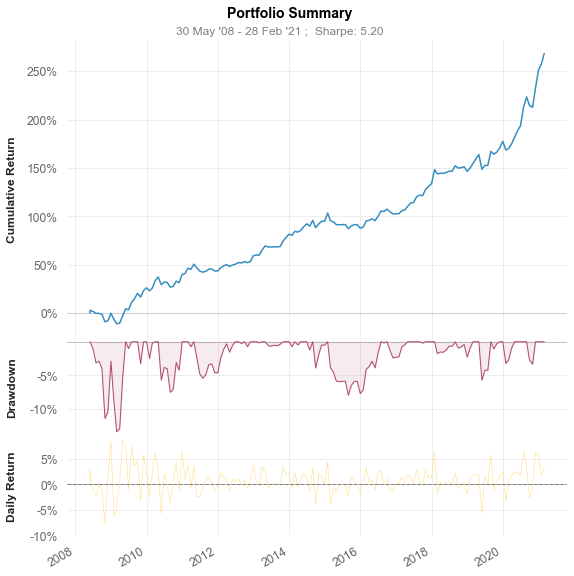

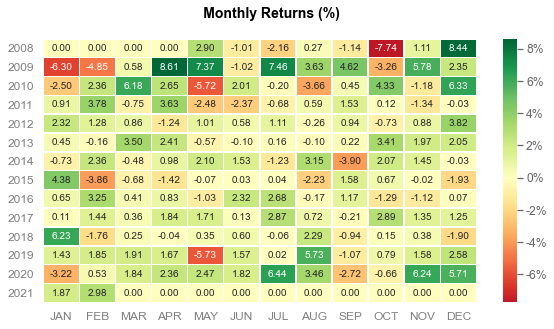

In [25]:
quantstats.reports.plots(DAAReturn['DAA'], mode='basic')